In [66]:
# ---------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 

# objects of the getBatch class will contain information about a 'batch' of data.  
# Look at the __init__ function at the bottom to see the different data members that 
# each getBatch object will contain
class getBatch:
    
    def getStockData(self,fileName, start, setupLength, predictLength):
        setupData = []
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        end = start + setupLength + predictLength -1
        predictStartDate = fLines[start + predictLength -1].split(',')[0]
        predictEndDate = fLines[start].split(',')[0]
        high = 0
        low = 1000000
        
        # get the 'old' stock data
        for i in range(end, start-1, -1):
            line = fLines[i].strip()
            lineArray = line.split(',')
            for k in range(1,7):
                lineArray[k] = float(lineArray[k])
            x = lineArray[6]/lineArray[4]

            if(i>=(start+predictLength)):
                for j in range(1,5):
                    setupData.append(lineArray[j]*x)
                setupData.append(lineArray[5])
        
            # get the high/low of 'new' stock data (we try and predict this)
            if(i<(start + predictLength)):
                if (lineArray[2]*x > high):
                    high = lineArray[2]*x
                if (lineArray[3]*x < low):
                    low = lineArray[3]*x

        futureClose = float(fLines[start].split(',')[4])*x
        lastDayClose = setupData[-2]
        oneHotLabel = [1,0]
        if(futureClose<lastDayClose):
            oneHotLabel = [0,1]


        file.close()


        # ----------------------convert data to 0=>1 instead of prices
        tmpHi = 0
        tmpLow = 1000000
        tmpVolHi = 1
        tmpVolLow = 1000000000

        for i in range(0,len(setupData)): # find the His and Lows for vol and price
            if(5*(i//5)+1 == i):
                if(setupData[i] >= tmpHi):
                    tmpHi = setupData[i]
            if(5*(i//5)+2 == i):
                if(setupData[i] < tmpLow):
                    tmpLow = setupData[i]
            if(5*(i//5)+4 == i):
                if(setupData[i] >= tmpVolHi):
                    tmpVolHi = setupData[i]
                if(setupData[i] < tmpVolLow):
                    tmpVolLow = setupData[i]

        if(tmpHi - tmpLow == 0): #special case where low and high are the same during the setupDays
            tmpLow = tmpLow - .10
        if(tmpVolHi - tmpVolLow == 0): #this will probably never be true, but hey
            tmpVolLow = tmpVolLow - .10 
                
        for i in range(0,len(setupData)): # convert the data to values between 0 and 1
            if(5*(i//5)+4 != i):
                setupData[i] = (setupData[i] - tmpLow)/(tmpHi-tmpLow)
            if(5*(i//5)+4 == i):
                setupData[i] = (setupData[i] - tmpVolLow)/(tmpVolHi-tmpVolLow)

        
        # store the normalized data...
                 # lastDayClose, adjustedFutureClose, realfutureClose, key
        targets = [lastDayClose,(futureClose-tmpLow)/(tmpHi-tmpLow),futureClose, [(tmpHi-tmpLow), tmpLow],
                  oneHotLabel]
        symbolAndPredictDates = [fileName.split('.')[0], predictStartDate, predictEndDate]

    #   get only the close price ?
        justCloseData = []
        for i in range(0,len(setupData)):
            if(5*(i//5)+3==i):
                justCloseData.append(setupData[i])

        
        return setupData, targets, symbolAndPredictDates



    def fetch(self, setupLength, predictLength):
        stockFiles = os.listdir('stockData')
        randIndex = random.randint(0,950)
    #     randIndex = 500
        fileName = stockFiles[randIndex]
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        file.close()
        start = random.randint(1, (len(fLines) - setupLength - predictLength - 1))
#         start=500
        spySetupData, spyLabels, labelDates = self.getStockData('SPY.txt',start,setupLength,predictLength)
        stockSetupData, stockTargets, labelDates = self.getStockData(fileName,start,setupLength,predictLength)
        setupData = []
    
        stockSetupData = np.asarray(stockSetupData,dtype=np.float32)
        spySetupData = np.asarray(spySetupData,dtype=np.float32)

        setupData.append(stockSetupData)
        setupData.append(spySetupData)
    
        setupData = np.reshape(setupData,(1,setupLength*10))
       
        return setupData, stockTargets, labelDates

    
    def __init__(self,setupLength,predictLength):
        self.setupData, self.targetData, self.labelData = self.fetch(setupLength,predictLength)
        self.oneHotLabel = self.targetData[4]
        self.lastDayClose = self.targetData[0]
        self.futureNormalizedClose = np.asarray([self.targetData[1]],dtype=np.float32)
        self.key = self.targetData[3]
        self.futureClose = self.targetData[2]
        self.stock = self.labelData
        
        
        
        
newBatch = getBatch(1,1)

print(newBatch.setupData)
print(newBatch.futureNormalizedClose)
print(newBatch.oneHotLabel)
print(newBatch.lastDayClose)
print(newBatch.futureClose)
print((newBatch.futureNormalizedClose)*newBatch.key[0] + newBatch.key[1])
print(newBatch.stock)



[[ 0.11570083  1.          0.          0.4380157   1.          0.43728891
   1.          0.          0.82033914  1.        ]]
[ 0.19834602]
[0, 1]
10.004208
9.882154
[ 9.88215351]
['EBAY', '2008-09-08', '2008-09-08']


In [69]:

node_length = 1000 # each day has ohlc... this number will be 5*setup days + 5*setupDays including spy data
num_nodes = 1000 # how many days in a 'setup'... unless you want to go back further...
num_unrollings = batch_size = 1



graph = tf.Graph()
with graph.as_default():

    # Placeholders:
    stock_data = tf.placeholder(tf.float32, [1, node_length]) # (10, 5) if 10 setup_days
    _day10 = tf.placeholder(tf.float32, [1]) # the close of the last setupDay
    _day11 = tf.placeholder(tf.float32, [1]) # just predicting one price... the close
    
    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    

    update = []
    # Definition of the cell computation.  leaving this here for reference
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state


    y1output = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False)
    y1state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    output, state = lstm_cell(stock_data, y1output, y1state)
            
    # make our readout Layer
    # go from last 'slice' of output (10, ) => (1, )
    w = tf.Variable(tf.truncated_normal([num_nodes, 1], -2, 2))
    b = tf.Variable(tf.constant(0.1, shape=[1]))
    last_slice = [output[batch_size-1,:]]
    prediction = tf.matmul(last_slice, w) + b
    
    
    # no classifying and linear regression, just minimizing difference
    loss = tf.abs(_day11 - prediction[0,:])
    optimizer = tf.train.AdagradOptimizer(7)
    train_step = optimizer.minimize(loss)   
    

    
    # --------------------------------------------------------------------------------------------------
    # training/algorithm loop
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    saver = tf.train.Saver()  # in order to store our variables once they've been trained!
    
    #training? or using pre-trained variables
    trainBool=False
    
    
    # arrays for storage
    realDataArray = []
    normalizedDataArray = []
    lossArray = []    
    
    if(trainBool==False):
        saver.restore(sess, "stock_predict{}_{}.ckpt".format(num_nodes,node_length))
        print("variables restored.")

    for i in range(10000):
        batch = getBatch(100, 21)
        normalizedLastDay = [(batch.lastDayClose - batch.key[1])/batch.key[0]]
        feed_dict = {stock_data: batch.setupData, _day10: normalizedLastDay, _day11: batch.futureNormalizedClose}
        
        # training?
        if(trainBool):
            sess.run(train_step, feed_dict)

        #store data
        predict = sess.run(prediction, feed_dict)
        realPredict = predict[0][0]*batch.key[0] + batch.key[1]
        if(realPredict>15):
            realDataArray.append([batch.lastDayClose, batch.futureClose, realPredict])
            normalizedDataArray.append([normalizedLastDay, batch.futureNormalizedClose, predict[0][0]])
            thisloss = sess.run(loss, feed_dict)
            lossArray.append(thisloss[0])
            
            if(i%1000 == 0):
                thisloss = sess.run(loss, feed_dict)
                lossArray.append(thisloss[0])
                print('loss at iteration {}: {}'.format(i, thisloss))
                print(batch.stock)
    for i in range(1):
        print('yay')
        if(trainBool):
            save_path = saver.save(sess, "stock_predict{}_{}.ckpt".format(num_nodes,node_length))
            print('all done, variables stored!')

   
    

variables restored.
loss at iteration 0: [ 0.12167609]
['ALL', '2009-03-27', '2009-04-27']
loss at iteration 1000: [ 0.35804814]
['HAL', '2012-04-12', '2012-05-10']
loss at iteration 2000: [ 0.09057036]
['JACK', '2010-09-09', '2010-10-07']
loss at iteration 3000: [ 0.10755005]
['SCPB', '2011-11-15', '2011-12-14']
loss at iteration 4000: [ 0.41282794]
['KRA', '2012-04-20', '2012-05-18']
loss at iteration 5000: [ 0.66930389]
['INCY', '2013-10-18', '2013-11-15']
loss at iteration 6000: [ 0.43088078]
['ABB', '2015-11-18', '2015-12-17']
loss at iteration 7000: [ 0.51917869]
['SH', '2015-04-30', '2015-05-29']
loss at iteration 8000: [ 0.14111912]
['MTB', '2008-03-03', '2008-04-01']
loss at iteration 9000: [ 0.43617857]
['RHI', '2013-07-22', '2013-08-19']
yay


average prediction delta: 0.36
$5000 initial investment...with sureModel predicting
   annual Surelongs initial return: $7311.15, 46.2230%
   annual Surelongs w/commision return: $7261.15, 45.2230%
   annual Surelongs slippage return: $7111.15, 42.2230%
   annual sureshorts initial return: $4123.30, -17.5340%
   annual sureshorts w/commision return: $4073.30, -18.5340%
   annual sureshorts slippage return: $3923.30, -21.5340%
$5000 initial investment...with model predicting
   annual longs initial return: $6126.05, 22.5211%
   annual longs w/commision return: $6076.05, 21.5211%
   annual longs slippage return: $5926.05, 18.5211%
   annual shorts initial return: $3898.75, -22.0251%
   annual shorts w/commision return: $3848.75, -23.0251%
   annual shorts slippage return: $3698.75, -26.0251%
$5000 initial investment...with random predicting
   annual rlongs initial return: $6112.15, 22.2430%
   annual rlongs w/commision return: $6062.15, 21.2430%
   annual rlongs slippage return: $5912.1

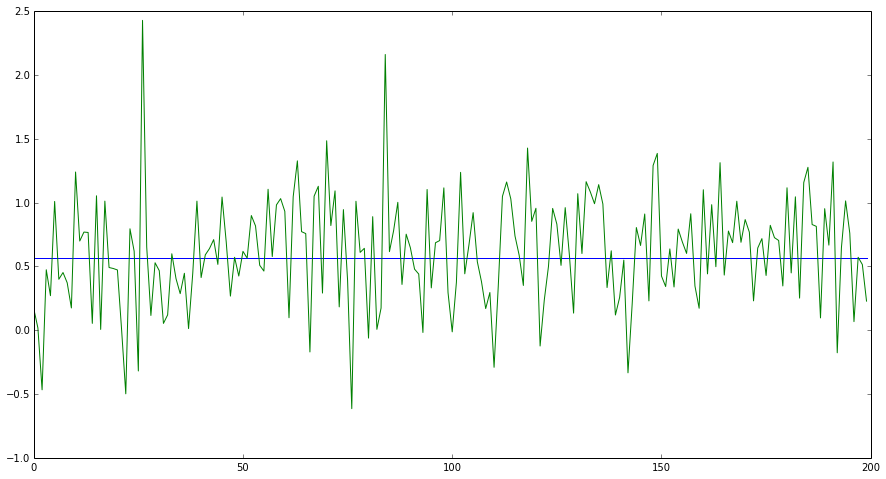

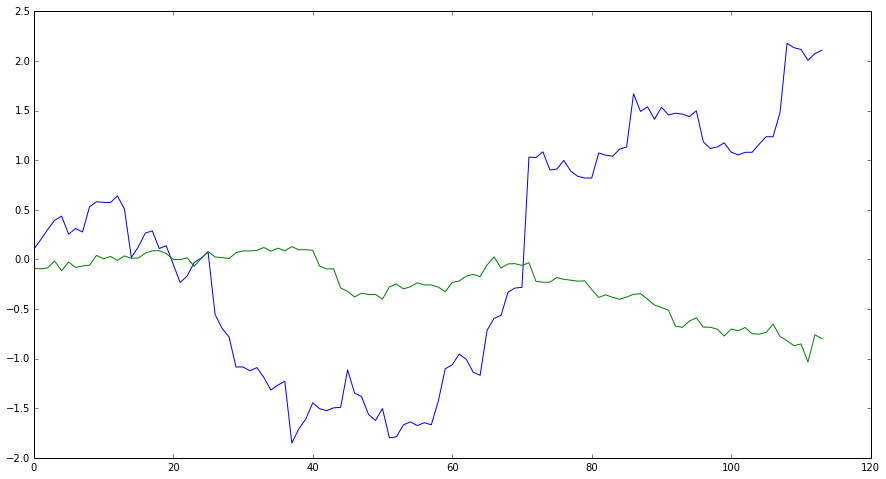

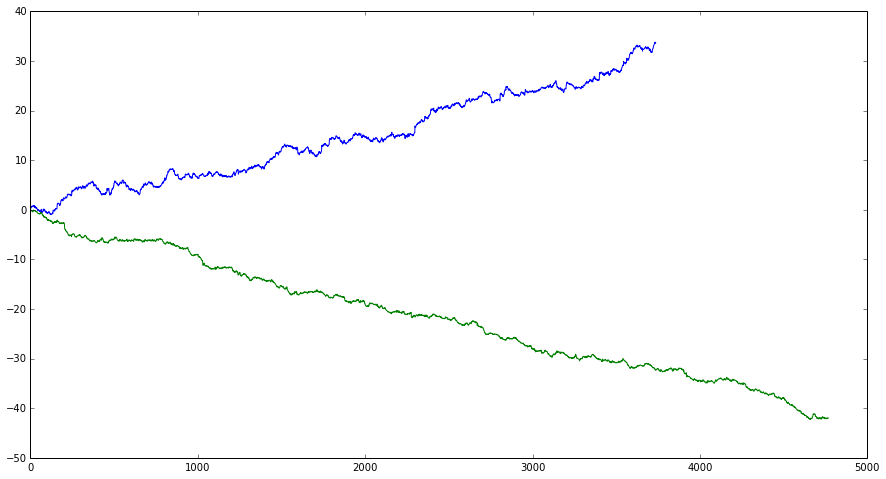

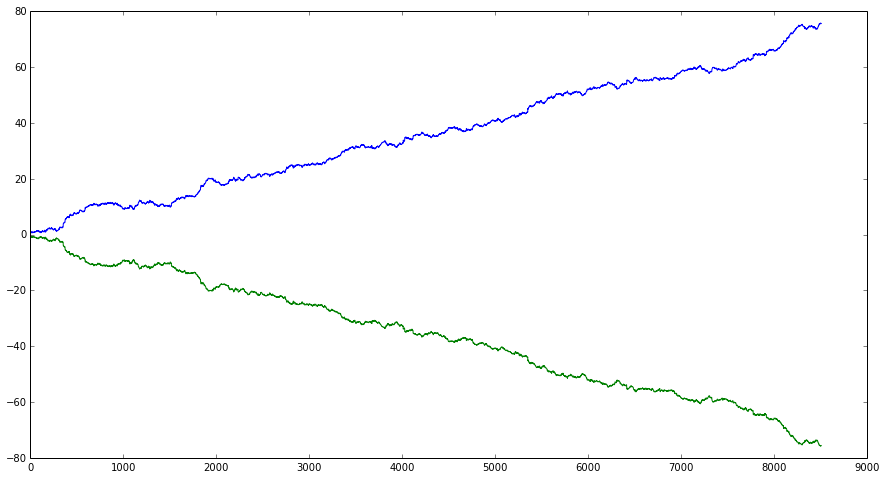

In [71]:
# for ref: realDataArray.append([batch.lastDayClose, batch.futureClose, realPredict])
#          normalizedDataArray.append([normalizedLastDay, batch.futureNormalizedClose, predict[0][0]])
            
# look for longs or shorts we were the most sure about (prediction vs todays price was very large)
sureLongPlots = []
sureLongPlotsTotal = 0
sureShortPlots = []
sureShortPlotsTotal = 0
pool_size = 75  #this is the size of the pool to take the largestPredictionDelta between vs. today's price
for i in range(0,len(normalizedDataArray),pool_size):
    index = 0
    longHi = 0
    shortHi =0
    num = len(normalizedDataArray) - i -1
    if(num > pool_size):
        num=pool_size
    for k in range(num):
        long = normalizedDataArray[i+k][2] - normalizedDataArray[i+k][0]
        if (long>0):
            if(normalizedDataArray[i+k][2]- normalizedDataArray[i+k][0]> longHi):
                longHi = normalizedDataArray[i+k][2] - normalizedDataArray[i+k][0]
                index = i+k
    sureLongPlotsTotal += (realDataArray[index][1] - realDataArray[index][0])/realDataArray[index][0]
    sureLongPlots.append(sureLongPlotsTotal)
    index=0
    for j in range(num):
        long = normalizedDataArray[i+j][2] - normalizedDataArray[i+j][0]
        if (long<0):
            if(normalizedDataArray[i+j][0] - normalizedDataArray[i+j][2] > shortHi):
                shortHi = normalizedDataArray[i+j][0] - normalizedDataArray[i+j][2]
                index = i+j
    sureShortPlotsTotal += (realDataArray[index][0] - realDataArray[index][1])/realDataArray[index][0]
    sureShortPlots.append(sureShortPlotsTotal)
    
    
# look for all trades, regardleses of how far the predicted price is from today's price
allLongPlots = []
allShortPlots = []
allShortPlotsTotal = 0
allLongPlotsTotal = 0
for i in range(len(normalizedDataArray)):
    if(realDataArray[i][2] > realDataArray[i][0]):
        allLongPlotsTotal += (realDataArray[i][1] - realDataArray[i][0])/realDataArray[i][0]
        allLongPlots.append(allLongPlotsTotal)
    else:
        allShortPlotsTotal += (realDataArray[i][0] - realDataArray[i][1])/realDataArray[i][0]
        allShortPlots.append(allShortPlotsTotal)

        
# calculate randoms          
rallLongPlots=[]        
rallShortPlots=[]
rallShortPlotsTotal = 0
rallLongPlotsTotal = 0
for i in range(len(realDataArray)):
#     add_ammount = (realDataArray[i][1] - realDataArray[i][0])/realDataArray[i][0]
    rallLongPlotsTotal += (realDataArray[i][1] - realDataArray[i][0])/realDataArray[i][0]
    rallLongPlots.append(rallLongPlotsTotal)
    rallShortPlotsTotal += (realDataArray[i][0] - realDataArray[i][1])/realDataArray[i][0]
    rallShortPlots.append(rallShortPlotsTotal)   

    
# make a loop to get all the predictions and the actuals
acts = []
pres = []
for i in range(len(normalizedDataArray)):
    acts.append(normalizedDataArray[i][1])
    pres.append(normalizedDataArray[i][2])
        
        
#plot out the lossArray 
plt.rcParams['figure.figsize'] = (15, 8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# ax1.plot(lossArray)  # blue
ax1.plot(pres[len(pres)-200:]) # green
ax1.plot(acts[len(acts)-200:]) 

#plot out just the 'big prediction delta' trades
plt.rcParams['figure.figsize'] = (15, 8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(sureLongPlots)  # blue
ax1.plot(sureShortPlots)  # green

#plot out all trades
plt.rcParams['figure.figsize'] = (15, 8)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(allLongPlots)  # blue
ax2.plot(allShortPlots) # green

#plot out random trades
plt.rcParams['figure.figsize'] = (15, 8)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(rallLongPlots)  # blue
ax2.plot(rallShortPlots) # green


def printReturns(totalsArray, name):
    tradesPerYear = 25
    dayAvg = totalsArray[len(totalsArray) - 1]/len(totalsArray)
    yearAvg = dayAvg*tradesPerYear
    investment = (5000 + 5000*yearAvg)#*(1 - 500*(.03/50))
    wComsReturn = investment - (tradesPerYear*2)
    wSlipReturn = investment - (tradesPerYear*2) - (tradesPerYear*2*(100*.03))
    print('   annual {} initial return: ${:.2f}, {:.4f}%'.format(name, investment, (investment/5000 - 1)*100))
    print('   annual {} w/commision return: ${:.2f}, {:.4f}%'.format(name, wComsReturn, (wComsReturn/5000 - 1)*100))
    print('   annual {} slippage return: ${:.2f}, {:.4f}%'.format(name, wSlipReturn, (wSlipReturn/5000 - 1)*100))
#     print('')
    

print('average prediction delta: {:.2f}'.format(np.mean(lossArray[0:])))
print('$5000 initial investment...with sureModel predicting')    
printReturns(sureLongPlots[0:],'Surelongs')
printReturns(sureShortPlots[0:],'sureshorts')

print('$5000 initial investment...with model predicting')    
printReturns(allLongPlots[0:],'longs')
printReturns(allShortPlots[:],'shorts')

print('$5000 initial investment...with random predicting')    
printReturns(rallLongPlots[0:],'rlongs')
printReturns(rallShortPlots[0:],'rshorts')

